In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

import scipy.interpolate as interpolate
import scipy.optimize as optimize

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import imp

import plotparams
imp.reload(plotparams)
from plotparams import *

import constants
imp.reload(constants)
from constants import *

import waveform
imp.reload(waveform)
from waveform import *

import waveformset as ws
imp.reload(waveform)

import pycbcwaveform
imp.reload(pycbcwaveform)
from pycbcwaveform import *

import taylorf2
imp.reload(taylorf2)
from taylorf2 import *

__init__: Setting weave cache to /var/folders/zl/bw0yy2l15g339xpfq2gmxh7c0000gn/T/501_python27_compiled/0f9d09/0f9d091579730f944829c2cd00d5501da9029cae


# Standard terminology for 2 waveform sets: Training Set, Validation Set

# Make conditioned FD waveforms

In [3]:
def truncate_beginning(h, xstart, remove_start_phase=False):
    """
    """
    ampint = h.interpolate('amp')
    phaseint = h.interpolate('phase')
    istart = np.searchsorted(h.x, xstart)
    if xstart == h.x[istart]:
        xnew = h.x[istart:]
    else:
        xnew = np.concatenate(([xstart], h.x[istart:]))
    return Waveform.from_amp_phase(xnew, ampint(xnew), phaseint(xnew), remove_start_phase=remove_start_phase)

In [4]:
def conditioned_waveform(q, lambda1, lambda2, mf_lower, 
                         delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start, 
                         approximant='TaylorT4'):
    """
    """
    # Generate waveform
    h = dimensionless_td_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, approximant=approximant)
    
    # Window the waveform
    h = window_waveform_in_frequency_interval(h, mfon_end, mfoff_start, mfoff_end)
    
    # extend the waveform
    ndata = len(h.x)
    times = h.x[0] + np.arange(0.0, length, delta_tbym)
    ntimes = len(times)
    ampall = np.zeros(ntimes)
    # Make phase continuous even when amplitude goes to zero (for fun)...
    phaseall = np.ones(ntimes)*h.phase[-1]
    ampall[:ndata] = h.amp
    phaseall[:ndata] = h.phase
    hextend = Waveform.from_amp_phase(times, ampall, phaseall)
    
    #fig, axes = plt.subplots(1, figsize=(16, 6))
    #plot_waveforms(axes, [h], xi=-np.inf, xf=np.inf, npoints=1000)
    
    # Fourier transform
    htilde = fourier_transform_waveform(hextend, delta_tbym)
    
    # Truncate waveform
    htrunc = truncate_beginning(htilde, mftrunc_start, remove_start_phase=True)
    
#     # Use the same time shift for all waveforms
#     htrunc.phase -= 2.0*np.pi*htrunc.x*tshift
#     htrunc.add_phase(remove_start_phase=True)
    return htrunc


def fit_time_phase_shift(freq, phase, phase_anal, f_fitend):
    """Fit the difference phase-phase_anal in the interval [freq[0], f_fitend).
    
    """
    # Data to fit a line to
    diff = phase - phase_anal
    i_fitend = np.searchsorted(freq, f_fitend)
    freq_data = freq[:i_fitend]
    diff_data = diff[:i_fitend]
        
    # The linear model
    def line_fit(x, a, b):
        return a + b*x
    
    # Do the least squares fit
    coeffs, covariances = optimize.curve_fit(line_fit, freq_data, diff_data)
    
    shifted_phase = phase - line_fit(freq, *coeffs)
    return shifted_phase


def match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend):
    """
    """
    # Taylor f2 phase
    f2_phase = taylorf2_phase(h.x, 0.0, 0.0, q/(1+q)**2, lambda1, lambda2)
    
    # Calculated the Shifted phase that matches TaylorF2 at the beginning
    shifted_phase = fit_time_phase_shift(h.x, h.phase, f2_phase, f_fitend)

    # Wrap then unwrap phase to correct for insufficient sampling of original waveform h
    comp_data = h.amp*np.exp(1.0j*shifted_phase)
    hnew = Waveform.from_complex(h.x, comp_data)
    
    # Change the start phase to exactly that of TaylorF2
    hnew.add_phase(f2_phase[0]-hnew.phase[0])
    
    return hnew

# Testing waveform preconditioning functions

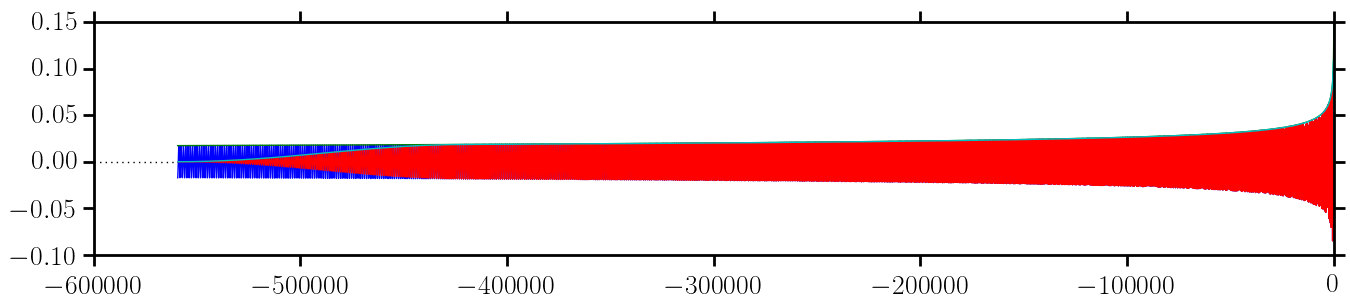

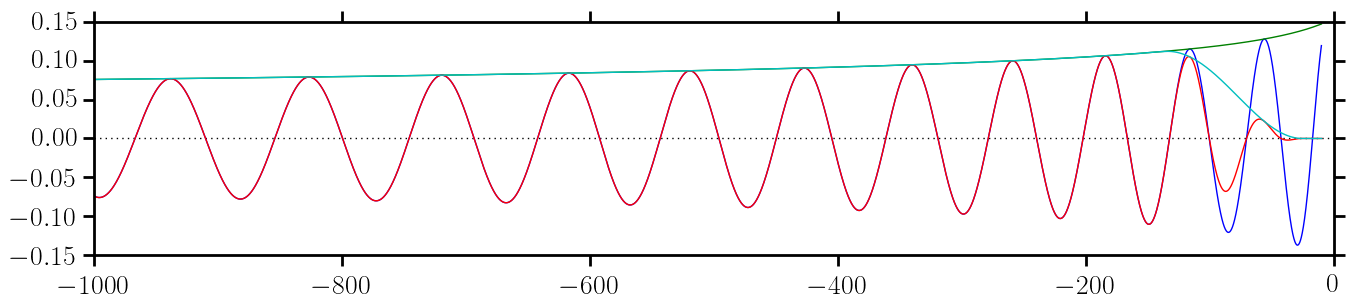

In [5]:
q, lambda1, lambda2 = 0.5, 0, 0
mf_lower, delta_tbym = 0.0009, 10.0
h = dimensionless_td_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, approximant='TaylorT4')
hwin = window_waveform_in_frequency_interval(h, 0.001, 0.015, 0.020)

fig, axes = plt.subplots(1, figsize=(16, 3))
plot_waveforms(axes, [h, hwin], npoints=10000)

fig, axes = plt.subplots(1, figsize=(16, 3))
plot_waveforms(axes, [h, hwin], xi=-1000, npoints=10000)

In [34]:
q, lambda1, lambda2 = 1.0, 500, 500
mf_lower, delta_tbym = 0.0009, 10.0
length = 1.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

h = conditioned_waveform(q, lambda1, lambda2, mf_lower, delta_tbym, length, mfon_end, mfoff_start, mfoff_end, mftrunc_start)
h = match_taylorf2_at_beginning(h, q, lambda1, lambda2, f_fitend)

# TaylorF2 waveform starting at the dimensionless frequency corresponding to 10Hz (for 1.4-1.4M_sun system).
f2_lower = f_to_mf(10, 2.8)
f2_upper = 0.1
hf2 = taylorf2(0, 0, q/(1+q)**2, lambda1, lambda2, f2_lower, f2_upper, 1.0e-5)

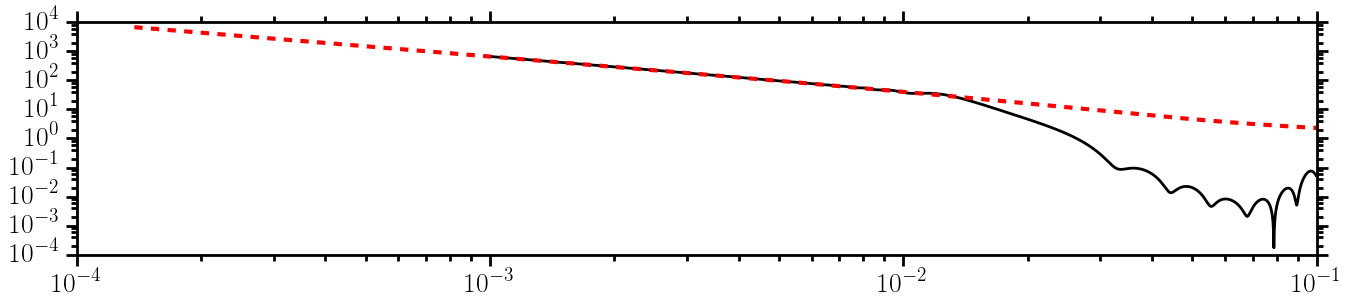

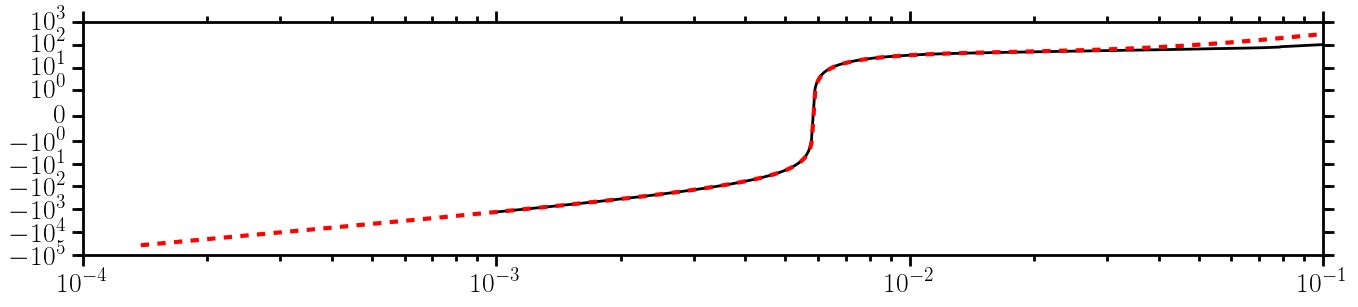

In [38]:
fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(h.x, h.amp, c='k', lw=2)
axes.plot(hf2.x, hf2.amp, c='r', lw=3, ls='--')
axes.set_xscale('log')
axes.set_yscale('log')

fig, axes = plt.subplots(1, figsize=(16, 3))
axes.plot(h.x, h.phase, c='k', lw=2)
axes.plot(hf2.x, hf2.phase, c='r', lw=3, ls='--')
axes.set_xscale('log')
axes.set_yscale('symlog', linthreshy=1.0)

In [8]:
q, lambda1, lambda2 = 1.0, 500, 500
params = np.linspace(0.5, 1.0, 11)
#params = np.linspace(0, 5000, 51)

mf_lower, delta_tbym = 0.0009, 10.0
length = 2.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

hlist = []
for p in params:
    print p, 
    h = conditioned_waveform(p, lambda1, lambda2, mf_lower, delta_tbym, 
                             length, mfon_end, mfoff_start, mfoff_end, mftrunc_start)
    h = match_taylorf2_at_beginning(h, p, lambda1, lambda2, f_fitend)
    hlist.append(h)

0.5 0.55 0.6 0.65 0.7 0.75 0.8 0.85 0.9 0.95 1.0


0.021 1522.69082638


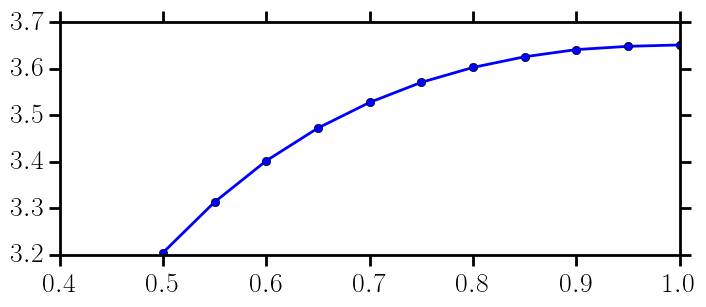

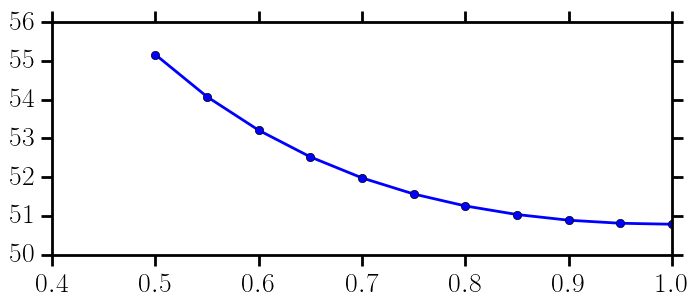

In [9]:
f = 0.021
print f, mf_to_f(f, 2.8)

amps = []
for h in hlist:
    amp = h.interpolate('amp')(f)
    amps.append(amp)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, amps, 'o', ls='-', lw=2)


phis = []
for h in hlist:
    phi = h.interpolate('phase')(f)
    phis.append(phi)
    
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(params, phis, 'o', ls='-', lw=2)

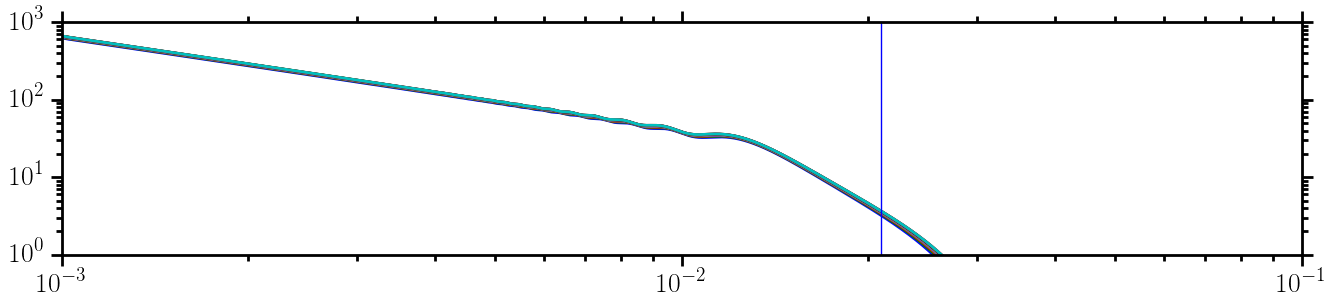

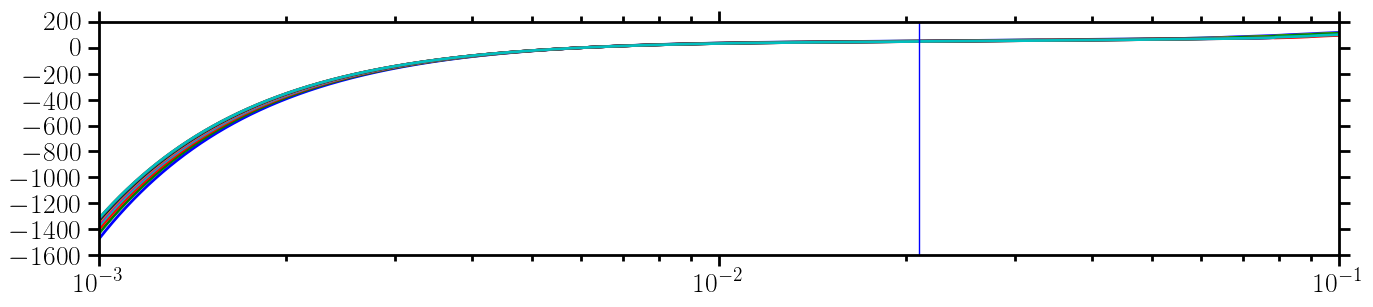

In [10]:
fig, axes = plt.subplots(1, figsize=(16, 3))
for h in hlist:
    axes.plot(h.x, h.amp, lw=2)
axes.axvline(f)
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_ylim(1.0e0, 1.0e3)


fig, axes = plt.subplots(1, figsize=(16, 3))
for h in hlist:
    axes.plot(h.x, h.phase, lw=2)
    #axes.plot(h.x, h.phase-hlist[0].phase, lw=2)
axes.axvline(f)
axes.set_xscale('log')

# Latin Hypercube

In [12]:
def latin_hypercube(Ndata, limits):
    """Select parameters using the Latin Hypercube method.
    
    Parameters
    ----------
    Ndata : int
        Number of points to select.
    limits : np.array([[x1_min, x1_max], [x2_min, x2_max], [x3_min, x3_max], ...])
        Boundaries of the hypercube.
    """
    Nparams = len(limits)
    
    # Find indices of grid points
    point_ind_list = []
    allowed_indices = np.array([[n for n in range(Ndata)] for i in range(Nparams)])
    for n in range(Ndata):
        js = np.random.randint(Ndata-n, size=Nparams)
        point_ind = [allowed_indices[i, js[i]] for i in range(Nparams)]
        point_ind_list.append(point_ind)
        allowed_indices = np.array([np.delete(allowed_indices[i], js[i]) for i in range(Nparams)])
    
    point_ind_array = np.array(point_ind_list)
    
    # Get grid points
    grids = []
    for i in range(Nparams):
        grids.append(np.linspace(limits[i, 0], limits[i, 1], Ndata))
    
    grids_array = np.array(grids)
    
    # Get chosen points on the grid
    points = np.array([[grids_array[i, point_ind_array[n, i]] for i in range(Nparams)] for n in range(Ndata)])
    
    return points

(0.0, 5000.0)

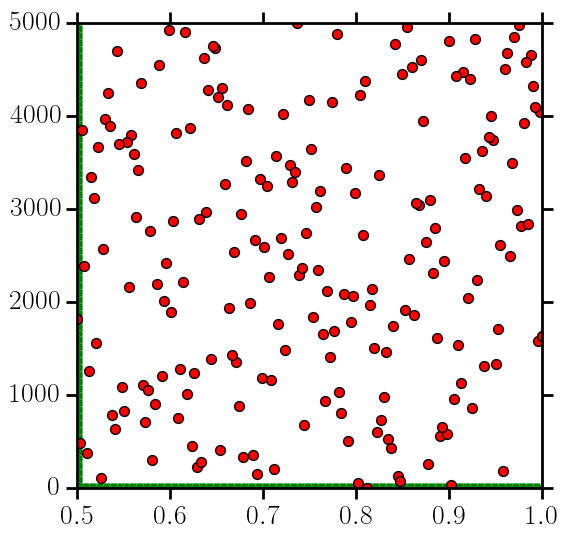

In [15]:
Ndata = 200
limits = np.array([[0.5, 1.0], [0, 5000], [0, 5000]])
points = latin_hypercube(Ndata, limits)

fig, axes = plt.subplots(figsize=(6, 6))

axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='x', s=50, lw=1, c='g')
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='x', s=50, lw=1, c='g')

axes.scatter(points[:, 0], points[:, 1], marker='o', s=50, lw=1, c='r')

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])

# Generate Training Set

In [ ]:
#from __future__ import print_function

In [14]:
ts = ws.HDF5WaveformSet('trainingset.hdf5')

In [16]:
mf_lower, delta_tbym = 0.0009, 10.0
length = 2.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

for i in range(len(points)):
    p = points[i]
    print i,
    #print(i, end="\r")
    h = conditioned_waveform(p[0], p[1], p[2], mf_lower, delta_tbym, 
                             length, mfon_end, mfoff_start, mfoff_end, mftrunc_start)
    h = match_taylorf2_at_beginning(h, p[0], p[1], p[2], f_fitend)
    ts.set_waveform(i, h, p)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199


# Interpolate with Gaussian process

In [17]:
class GaussianProcess(object):
    """
    """
    def __init__(self, params, y, cov, *covargs):
        """Gaussian Process for n dimensional set of data.
        
        Parameters
        ----------
        params : list of length n arrays.
            Parameters of sampled data.
        y : list of length n.
            Data at each of the sampled parameters.
        cov : func(*covargs)
            Covariance function.
        covargs : args
            Arguments for the covariance function.
        """
        self.cov = cov
        self.covargs = covargs
        self.params = params
        self.y = y
        
        # Evaluate K and K^{-1}
        self.K = np.array([[self.cov(p1, p2, *self.covargs) for p2 in self.params] for p1 in self.params])
        self.Kinv = np.linalg.inv(self.K)

    def __call__(self, ps):
        """Evaluate the function and estimate the error at the points ps.
        
        Parameters
        ----------
        ps : list of length n arrays.
            Points where you want to evaluate the function.
        
        Returns
        -------
        ys : array of length n
            Interpolated value at each point ps.
        sqrt(ysvar) : array of length n
            Estimate of the interpolation error at each point ps.
        """
        # Evaluate K_*, K_**
        Ks = np.array([self.cov(ps, p1, *self.covargs) for p1 in self.params])
        Kss = self.cov(ps, ps, *self.covargs)
        
        # Evaluate y_*
        Kinv_y = np.dot(self.Kinv, self.y)
        ys = np.dot(Ks, Kinv_y)
        
        # Evaluate variance at y_*
        ysvar = Kss - np.dot(Ks, np.dot(self.Kinv, Ks.T) )
        
        return ys, np.sqrt(ysvar)
    
    
#     def sample_gaussian_process(self, ps):
#         """
#         """
#         # Evaluate K_*, K_**
#         Ks = np.array([self.cov(ps, p1, *self.covargs) for p1 in self.params])
#         Kss = self.cov(ps, ps, *self.covargs)
        
#         # Evaluate y_*
#         Kinv_y = np.dot(self.Kinv, self.y)
#         ys = np.dot(Ks, Kinv_y)
        
#         # Evaluate variance at y_*
#         ysvar = Kss - np.dot(Ks, np.dot(self.Kinv, Ks.T) )
        
#         ysample = np.random.normal(ys, np.sqrt(ysvar))
#         return ysample

In [18]:
# sigma_f:
# Maximum covariance between two points p1, p2.
# K = sigma_f^2 + sigma_n^2 when p1=p2
# Give sigma_f a larger value when data has a large range of values.

def covnd(p1, p2, sigma_f, sigma_n, ls):
    """Covariance function for n-d parameter space.
    
    Parameters
    ----------
    p1 : listlike length n
        Point 1
    p2 : listlike length n
        Point 2
    sigma_f : float
        Maximum covariance between two points
    sigma_n : float
        Scale parameter for error in data
    ls : listlike length n
        Length scale for correlation in each dimension
    """
    Nparams = len(ls)
    
    if np.array_equal(p1, p2):
        nugget = sigma_n**2
    else:
        nugget = 0.0
    
    squares = np.array([-(p1[i]-p2[i])**2 / (2*ls[i]**2) for i in range(Nparams)])
    lnexp = np.sum(squares)
    return sigma_f**2 * np.exp(lnexp) + nugget

# Test Gaussian Process Regression
## Phase difference

In [19]:
# The points for your testset
lambda1, lambda2 = 500, 500
points = np.array([[q, lambda1, lambda2] for q in np.linspace(0.5, 1.0, 51)])

# Evaluate waveforms in your test set
testset = ws.HDF5WaveformSet('testset.hdf5')

mf_lower, delta_tbym = 0.0009, 10.0
length = 2.0e6
mfon_end, mfoff_start, mfoff_end = 0.001, 0.015, 0.020
mftrunc_start = mfon_end
f_fitend = 0.002

for i in range(len(points)):
    p = points[i]
    print i, 
    h = conditioned_waveform(p[0], p[1], p[2], mf_lower, delta_tbym, 
                             length, mfon_end, mfoff_start, mfoff_end, mftrunc_start)
    h = match_taylorf2_at_beginning(h, p[0], p[1], p[2], f_fitend)
    testset.set_waveform(i, h, p)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50


In [241]:
mf = 0.02

# Evaluate dphases = phases - phases_f2 for waveforms in the test set
test_params = testset.parameters()
test_phases = np.array([testset.get_waveform(i).interpolate('phase')(mf) for i in range(len(testset))])
test_phases_f2 = np.array([taylorf2_phase(mf, 0, 0, p[0]/(1+p[0])**2, p[1], p[2]) for p in test_params])
test_dphases = test_phases - test_phases_f2

# Evaluate dphases = phases - phases_f2 for waveforms in the training set
train_params = ts.parameters()
train_phases = np.array([ts.get_waveform(i).interpolate('phase')(mf) for i in range(len(ts))])
train_phases_f2 = np.array([taylorf2_phase(mf, 0, 0, p[0]/(1+p[0])**2, p[1], p[2]) for p in train_params])
train_dphases = train_phases - train_phases_f2

In [242]:
# # Interpolate with GPR
# sigma_f = 0.01
# sigma_n = 0.002
# ls = np.array([0.5, 5000.0, 5000.0])
# gp = GaussianProcess(train_params, train_dphases, covnd, sigma_f, sigma_n, ls)

# Interpolate with GPR
sigma_f = 10.0
sigma_n = 0.002
ls = np.array([0.5, 5000.0, 5000.0])
gp = GaussianProcess(train_params, train_dphases, covnd, sigma_f, sigma_n, ls)

In [243]:
# Interpolate at the same points as the test set
dphases_gp, dphases_gp_err = np.array([gp(test_params[i]) for i in range(len(test_params))]).T

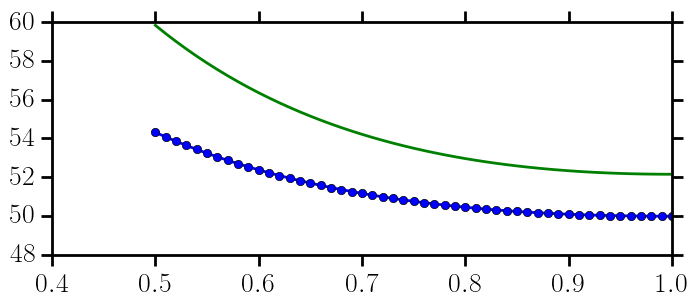

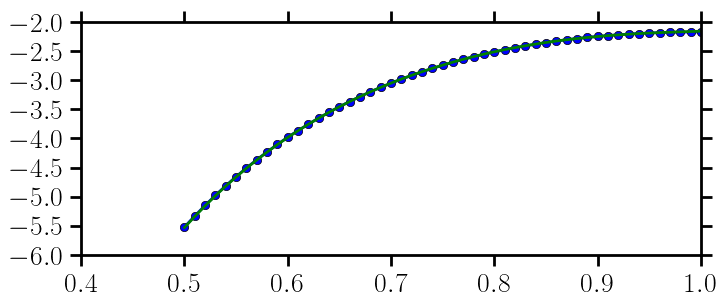

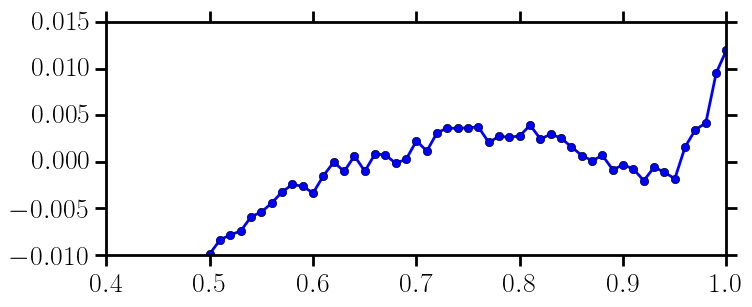

In [244]:
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(test_params[:, 0], test_phases, 'o', ls='-', lw=2)
axes.plot(test_params[:, 0], test_phases_f2, ls='-', lw=2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(test_params[:, 0], test_dphases, 'o', ls='-', lw=2)
axes.plot(test_params[:, 0], dphases_gp, ls='-', lw=2)
#axes.plot(test_params[:, 0], dphases_gp-dphases_gp_err, ls='-', lw=2)
#axes.plot(test_params[:, 0], dphases_gp+dphases_gp_err, ls='-', lw=2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(test_params[:, 0], dphases_gp - test_dphases, 'o', ls='-', lw=2)

## Fractional amplitude error term

In [237]:
mf = 0.015

# Evaluate dfrac_amp = amp / amp_f2 - 1 for waveforms in the test set
test_params = testset.parameters()
test_amps = np.array([testset.get_waveform(i).interpolate('amp')(mf) for i in range(len(testset))])
test_amps_f2 = np.array([taylorf2_amp(mf, p[0]/(1+p[0])**2) for p in test_params])
test_dfrac_amp = test_amps / test_amps_f2 - 1.0

# Evaluate dfrac_amp = amp / amp_f2 - 1 for waveforms in the training set
train_params = ts.parameters()
train_amps = np.array([ts.get_waveform(i).interpolate('amp')(mf) for i in range(len(ts))])
train_amps_f2 = np.array([taylorf2_amp(mf, p[0]/(1+p[0])**2) for p in train_params])
train_dfrac_amp = train_amps / train_amps_f2 - 1.0

In [238]:
# Interpolate with GPR
sigma_f = 1
sigma_n = 0.001
ls = np.array([0.5, 5000.0, 5000.0])
gp_amp = GaussianProcess(train_params, train_dfrac_amp, covnd, sigma_f, sigma_n, ls)

In [239]:
# Interpolate at the same points as the test set
dfrac_amp_gp, dfrac_amp_gp_err = np.array([gp_amp(test_params[i]) for i in range(len(test_params))]).T

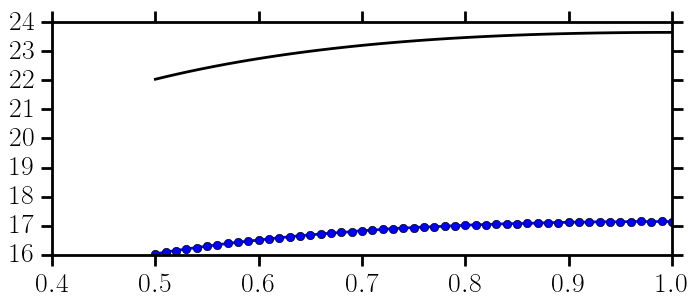

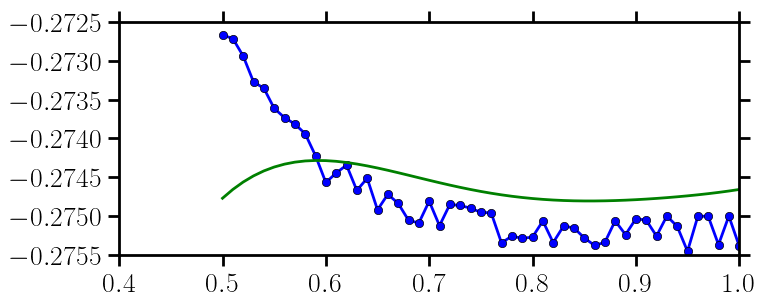

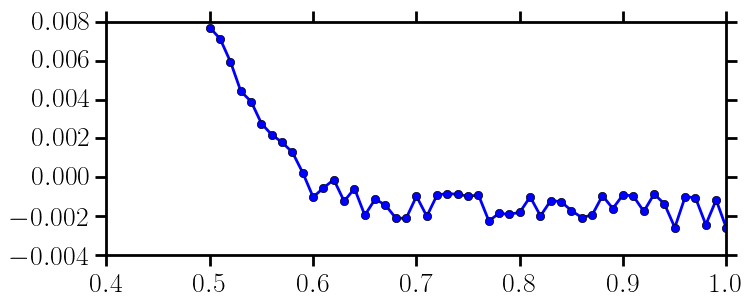

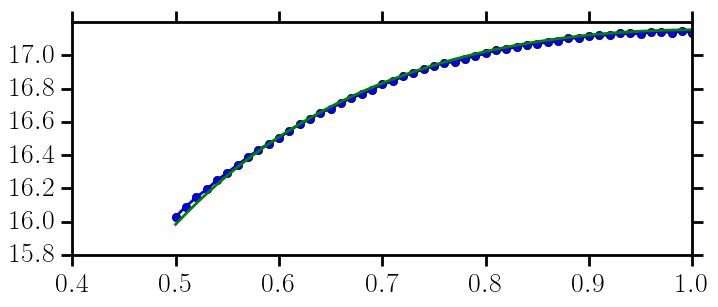

In [240]:
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(test_params[:, 0], test_amps, 'o', ls='-', lw=2)
axes.plot(test_params[:, 0], test_amps_f2, c='k', ls='-', lw=2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(test_params[:, 0], test_dfrac_amp, 'o', ls='-', lw=2)
axes.plot(test_params[:, 0], dfrac_amp_gp, ls='-', lw=2)
#axes.plot(test_params[:, 0], dphases_gp-dphases_gp_err, ls='-', lw=2)
#axes.plot(test_params[:, 0], dphases_gp+dphases_gp_err, ls='-', lw=2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(test_params[:, 0], dfrac_amp_gp / test_dfrac_amp - 1, 'o', ls='-', lw=2)

fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(test_params[:, 0], test_amps, 'o', ls='-', lw=2)
axes.plot(test_params[:, 0], (1.0+dfrac_amp_gp)*test_amps_f2, ls='-', lw=2)

# Optimize covariance hyperparameters with MCMC

In [211]:
def lnlike(params, y, cov, *covargs):
    Nparams = len(params[0])
    # Evaluate K and K^{-1}
    K = np.array([[cov(p1, p2, *covargs) for p2 in params] for p1 in params])
    Kinv = np.linalg.inv(K)
    Kdet = np.linalg.det(K)
    #print Kdet
    #return -0.5*np.dot(y.T, np.dot(Kinv, y)) - 0.5*np.log(Kdet) - 0.5*Nparams*np.log(2.0*np.pi)
    return -0.5*np.dot(y.T, np.dot(Kinv, y))

def lnprior(covparams):
    sigma_f = covparams[0]
    sigma_n = covparams[1]
    ls0 = covparams[2]
    ls1 = covparams[3]
    ls2 = covparams[4]
    
    if (0.1 < sigma_f < 10.0 and  0.001 < sigma_n < 1.0 and 
        0.05 < ls0 < 5.0 and 100 < ls1 < 10000.0 and 100 < ls2 < 10000.0):
        return 0.0
    return -np.inf

def lnpost(covparams, params, y, cov):
    lp = lnprior(covparams)
    covargs = (covparams[0], covparams[1], np.array([covparams[2], covparams[3], covparams[3]]))
    return lp + lnlike(params, y, cov, *covargs) if np.isfinite(lp) else -np.inf


# def lnlike(params, y, cov, *covargs):
#     Nparams = len(params[0])
#     # Evaluate K and K^{-1}
#     K = np.array([[cov(p1, p2, *covargs) for p2 in params] for p1 in params])
#     Kinv = np.linalg.inv(K)
#     Kdet = np.linalg.det(K)
#     return -0.5*np.dot(y.T, np.dot(Kinv, y)) - 0.5*np.log(Kdet) - 0.5*Nparams*np.log(2.0*np.pi)
    
# def lnprior(covparams):
#     sigma_f = covparams[0]
#     sigma_n = covparams[1]
#     ls0 = covparams[2]
#     ls1 = covparams[3]
    
#     if (0.1 < sigma_f < 10.0 and  0.001 < sigma_n < 0.02 and 
#         0.2 < ls0 < 10.0 and 0.2 < ls1 < 50.0):
#         return 0.0
#     return -np.inf

# def lnpost(covparams, params, y, cov):
#     lp = lnprior(covparams)
#     covargs = (covparams[0], covparams[1], np.array([covparams[2], covparams[3]]))
#     return lp + lnlike(params, y, cov, *covargs) if np.isfinite(lp) else -np.inf

In [212]:
lnpost(np.array([1, 0.01, 0.5, 5000, 5000]), train_params, train_dfrac_amp, covnd)

-1.7097396338355098

In [213]:
def sample_walkers_uniformly_from_prior(nwalkers, limits, lnprior):
    """Place initial position of walkers uniformly in prior.
    This function removes points where lnprior is not 0.0.
    EMCEE walkers get lost if they start outside the prior region.
    """
    ndim = len(limits)
    pos = []
    for i in range(nwalkers):
        while True:
            p = limits[:, 0] + (limits[:, 1]-limits[:, 0])*np.random.rand(ndim)
            if lnprior(p) == 0.0:
                break
        pos+=[p]
        
    return pos

In [223]:
nwalkers = 16
ndim = 5
limits = np.array([
            [0.1, 10.0], 
            [0.001, 1.0], 
            [0.05, 5.0], 
            [100.0, 10000.0], 
            [100.0, 10000.0]
        ])
pos = sample_walkers_uniformly_from_prior(nwalkers, limits, lnprior)

In [225]:
#[lnpost(p, train_params, train_dfrac_amp, covnd) for p in pos]

In [226]:
import emcee
import time

In [227]:
# Initialize the EnsembleSampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=[train_params, train_dfrac_amp, covnd], threads=8)

t0 = time.clock()

# Run the production chain.
nsteps = 2
sampler.run_mcmc(pos, nsteps, rstate0=np.random.get_state(), thin=1)

t1 = time.clock()
t1-t0

KeyboardInterrupt: 

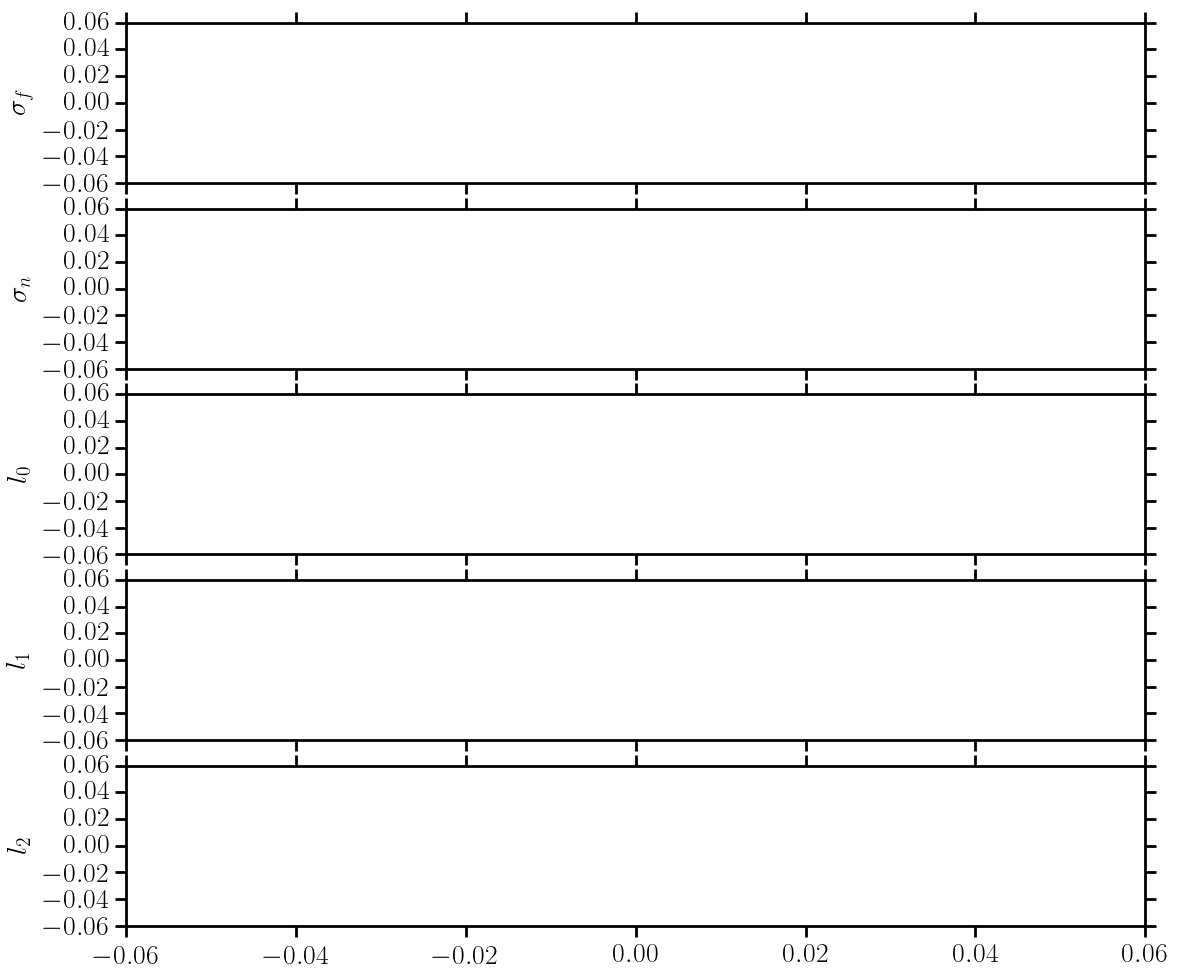

In [218]:
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(12, 10))

labels = [r'$\sigma_f$', r'$\sigma_n$', r'$l_0$', r'$l_1$', r'$l_2$']

for i in range(ndim):
    axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=0.4)
    axes[i].set_ylabel(labels[i])

fig.tight_layout(h_pad=0.0)

In [201]:
xs = np.logspace(-1, 5, 11)
lnp = [lnpost(np.array([x, 0.01, 0.5, 5000, 5000]), train_params, train_dfrac_amp, covnd) for x in xs]

In [202]:
lnp

[-inf,
 -1.8030903404276444,
 -1.6491793376481092,
 -1.4481638208269023,
 -1.2268202151209522,
 -1.0204235580587271,
 -0.84927656958038555,
 -0.70228976501875151,
 -0.53558463418779345,
 -0.35424030179953969,
 -inf]

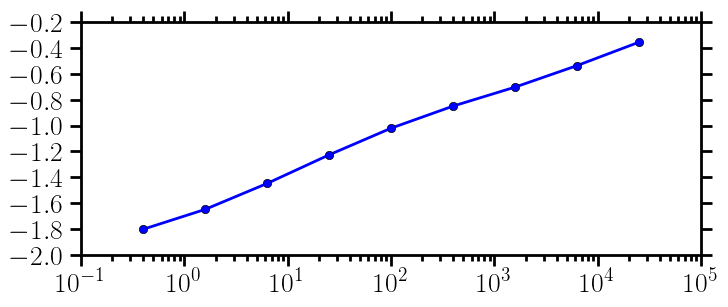

In [203]:
fig, axes = plt.subplots(1, figsize=(8, 3))
axes.plot(xs, lnp, 'o', ls='-', lw=2)
axes.set_xscale('log')